In [26]:
import sys
sys.path.append('/global/homes/y/yzh/.local/cmbenv-20220322/lib/python3.9/site-packages/')
import cosmoglobe
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pathlib
from tqdm import tqdm

In [27]:
# 5) Compute posterior mean and RMS for the following quantities, using your
#    favorite tools (healpy or whatever)
#    a) CMB map (use cmb_c0001_k*.fits)
#    b) Frequency sky map (use tod_030_map_c0001_k*.fits)
#    c) Correlated noise (use tod_030_ncorr_c0001_k*.fits)
#    d) Absolute gain for detector 27M (use chain_c0001.h5)
#    e) Gain as a function of time for detector 27M (use chain HDF file)
#    f) Chisq as a function of time for detector 27M (use chain HDF file)

# 6) Compute (posterior mean - input)/posterior rms for each quantity, and
#    compare with an N(0,1) distribution

In [58]:
root_path = pathlib.Path('./AST9240')
chains_dir = root_path.joinpath('chains_sim').resolve()
data_dir = root_path.joinpath('data').resolve()
input_dir = root_path.joinpath('chains_sim_input').resolve()

input_chain  = cosmoglobe.Chain(f"{data_dir}/chain_init_BP10.5.h5")
output_chain = cosmoglobe.Chain(f"{chains_dir}/chain_c0001.h5")

In [75]:
#maps
# input_cmb = hp.ud_grade(hp.read_map(input_dir.joinpath('cmb_c0001_k0000000.fits'), field=None), 512) #Using this map has no bias in intensity
input_cmb = hp.ud_grade(hp.read_map(data_dir.joinpath('cmb_map.fits'), field=None), 512) #Using this map has a bias in intensity
input_cn = hp.read_map(input_dir.joinpath('tod_030_ncorr_c0001_k000001.fits'), field=None)

input_fm = input_cmb + input_cn #Not sure what to do here

#gain
output_gain = output_chain.get("tod/030/gain")
input_gain = input_chain.get("tod/030/gain")[3]

In [70]:
start_sample=100
end_sample=1100
nsamp = end_sample-start_sample+1

In [48]:
cmb_mean = np.zeros_like(input_cmb)
cmb_rms = np.zeros_like(input_cmb)

fm_mean = np.zeros_like(input_fm)
fm_rms = np.zeros_like(input_fm)

cn_mean = np.zeros_like(input_cn)
cn_rms = np.zeros_like(input_cn)

# fm_cn_mean = np.zeros_like(input_fm)
# fm_cn_rms = np.zeros_like(input_fm)

gain_mean = np.zeros_like(input_gain)
gain_rms = np.zeros_like(input_gain)

for i in tqdm(range(start_sample, end_sample+1)):
    m_cmb = hp.ud_grade(hp.read_map(chains_dir.joinpath(f'cmb_c0001_k00{str(i).zfill(4)}.fits').resolve(), field=None), 512)
    cmb_mean += m_cmb
    cmb_rms += m_cmb**2
    
    m_freq = hp.read_map(chains_dir.joinpath(f'tod_030_map_c0001_k00{str(i).zfill(4)}.fits').resolve(), field=None)
    fm_mean += m_freq
    fm_rms += m_freq**2
    
    m_ncorr = hp.read_map(chains_dir.joinpath(f'tod_030_ncorr_c0001_k00{str(i).zfill(4)}.fits').resolve(), field=None)
    cn_mean += m_ncorr
    cn_rms += m_ncorr**2
    
    # diff = m_freq - m_ncorr 
    # fm_cn_mean += diff
    # fm_cn_rms += diff**2
    
    gain = output_gain[i]
    gain_mean += gain
    gain_rms += gain**2
    
cmb_rms = np.sqrt(cmb_rms/nsamp - (cmb_mean/nsamp)**2)
cmb_mean /= nsamp

fm_rms = np.sqrt(fm_rms/nsamp - (fm_mean/nsamp)**2)
fm_mean /= nsamp

cn_rms = np.sqrt(cn_rms/nsamp - (cn_mean/nsamp)**2)
cn_mean /= nsamp

# fm_cn_rms = np.sqrt(fm_cn_rms/nsamp - (fm_cn_mean/nsamp)**2)
# fm_cn_mean /= nsamp

gain_rms = np.sqrt(gain_rms/nsamp - (gain_mean/nsamp)**2)
gain_mean /= nsamp

np.save('results/cmb_mean', cmb_mean)
np.save('results/cmb_rms', cmb_rms)

np.save('results/fm_mean', fm_mean)
np.save('results/fm_rms', fm_rms)

np.save('results/cn_mean', cn_mean)
np.save('results/cn_rms', cn_rms)

# np.save('results/fm_cn_mean', fm_cn_mean)
# np.save('results/fm_cn_rms', fm_cn_rms)

np.save('results/gain_mean', gain_mean)
np.save('results/gain_rms', gain_rms)

In [49]:
# cmb_mean = np.load('results/cmb_mean.npy')
# cmb_rms = np.load('results/cmb_rms.npy')

# fm_mean = np.load('results/fm_mean.npy')
# fm_rms = np.load('results/fm_rms.npy')

# cn_mean = np.load('results/cn_mean.npy')
# cn_rms = np.load('results/cn_rms.npy')

# gain_mean = np.load('results/gain_mean.npy')
# gain_rms = np.load('results/gain_rms.npy')

In [50]:
def gaussian(x, nu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp((-(x-nu)**2)/(2*sigma**2))

In [85]:
def plot_map_result(input_map, mean_map, rms_map, name):
    
    m_matrix = np.array([input_map, mean_map, rms_map])

    fig, axes = plt.subplots(3,3, figsize=(20, 20))

    for col in range(3):
        for row in range(3):
            plt.axes(axes[col][row])
            hp.mollview(m_matrix[col][row], hold=True, title='')
            
    plt.show()
    
    d = (mean_map - input_map) / rms_map
    print(np.min(d), np.max(d))
    plt.savefig(f'{name}_map.png', facecolor='w')
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_title('I (posterior_mean - input / std)')
    axes[0].hist(d[0], bins=50, ec='black',density=True)

    axes[1].set_title('Q (posterior_mean - input / std)')
    axes[1].hist(d[1], bins=50, ec='black',density=True)

    axes[2].set_title('U (posterior_mean - input / std)')
    axes[2].hist(d[2], bins=50, ec='black',density=True)

    x = np.linspace(-5, 5, 100)
    for ax in axes.flat:
        ax.grid()
        ax.plot(x, gaussian(x,0,1))
        # ax.set_xlim([-5,5])
        
    plt.show()
    plt.savefig(f'{name}_hist.png', facecolor='w')

# CMB

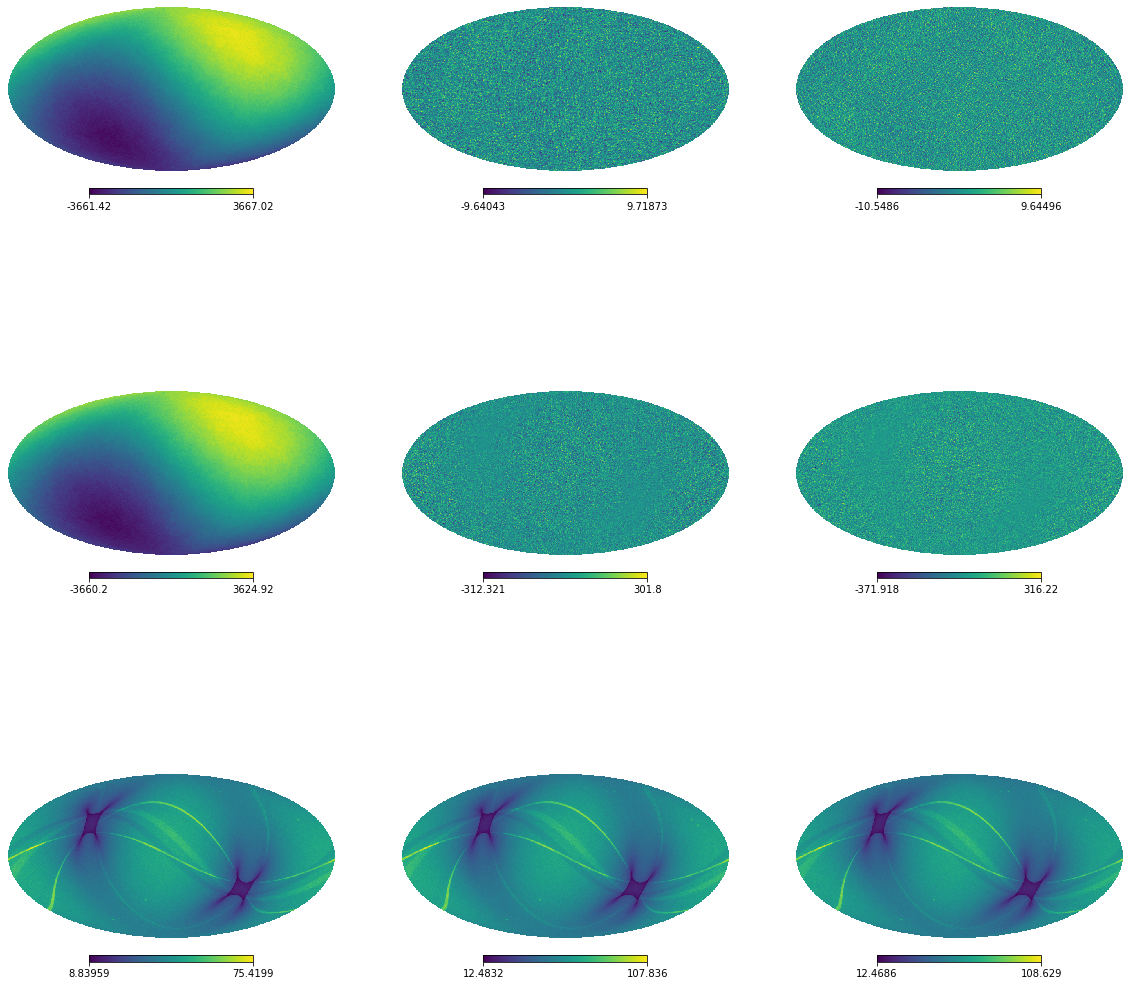

-9.866569344843017 7.43447372757312


<Figure size 432x288 with 0 Axes>

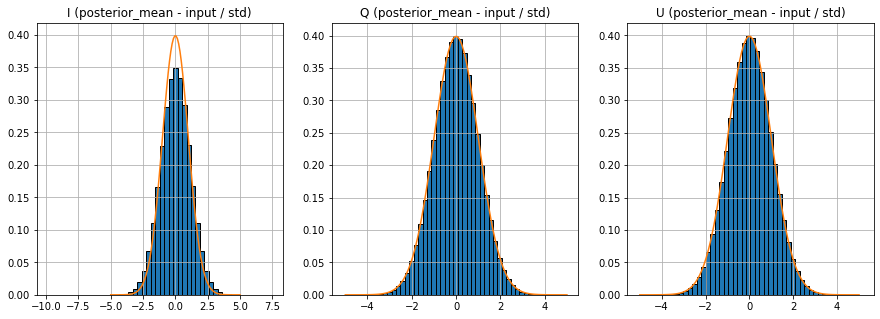

<Figure size 432x288 with 0 Axes>

In [87]:
plot_map_result(input_cmb, cmb_mean, cmb_rms, 'cmb')

# NCORR

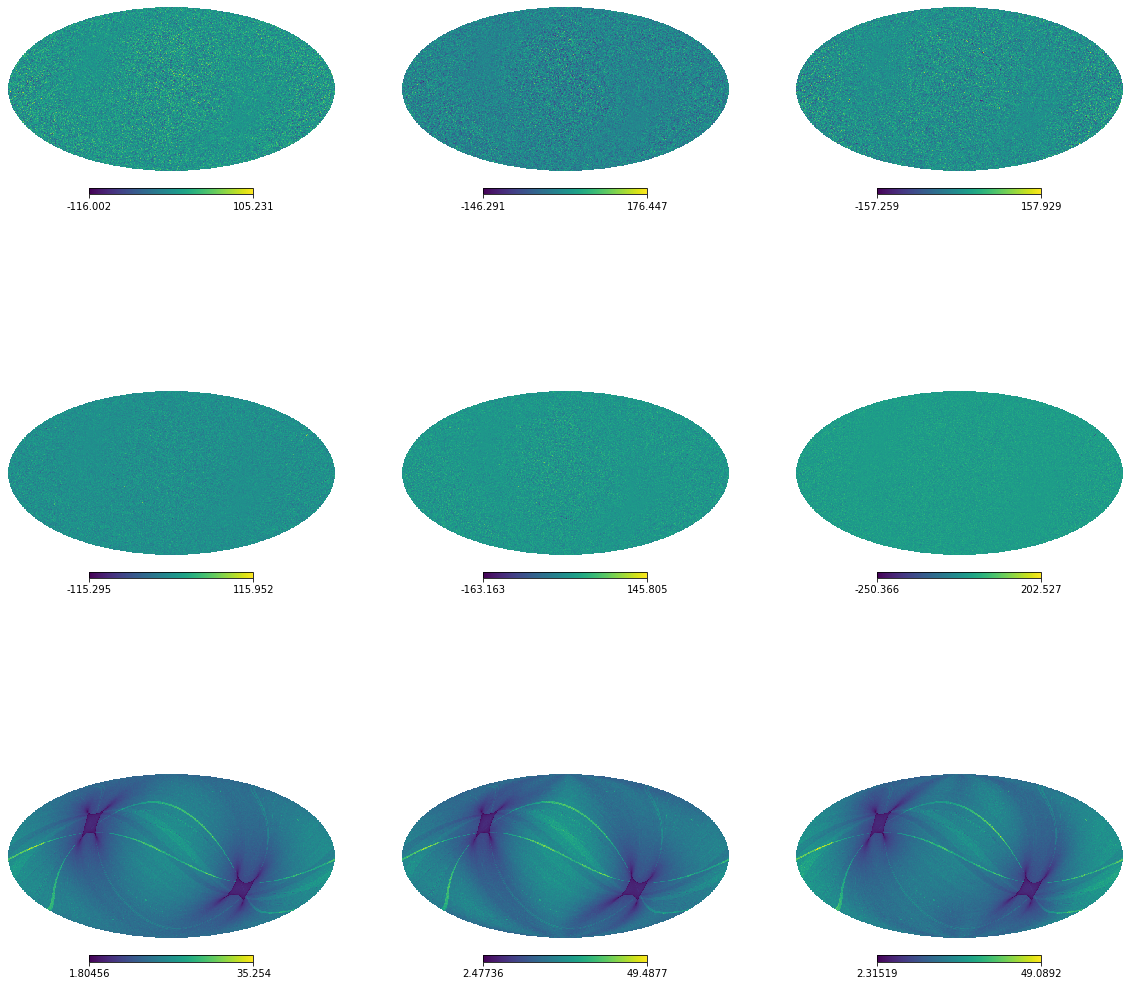

-20.46523055801511 19.57480357264692


<Figure size 432x288 with 0 Axes>

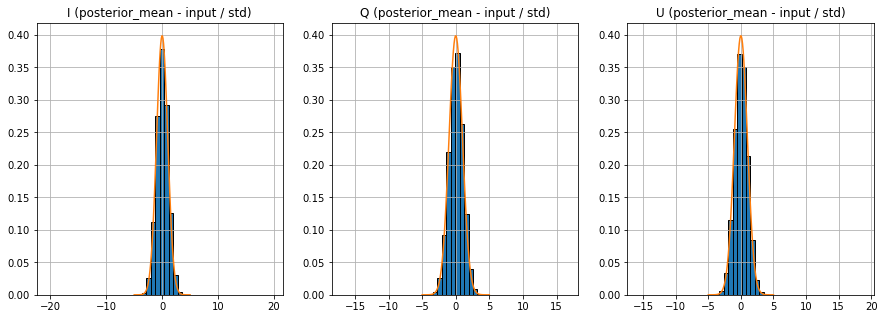

<Figure size 432x288 with 0 Axes>

In [88]:
plot_map_result(input_cn, cn_mean, cn_rms, 'cn')

# FREQ

In [54]:
#Assumption: freq_map = cmb_map + n_corr (+white noise?)
#Not sure what to compare here

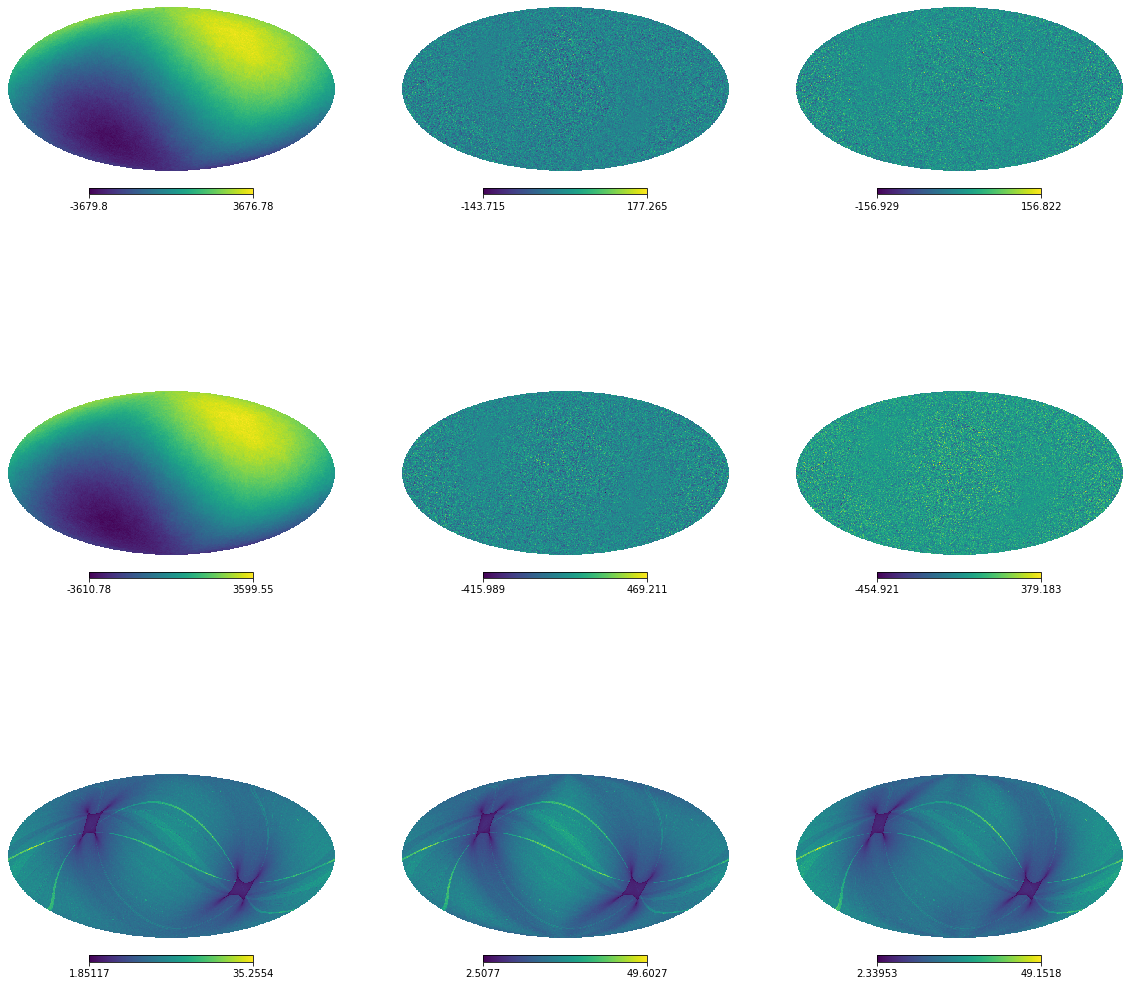

<Figure size 432x288 with 0 Axes>

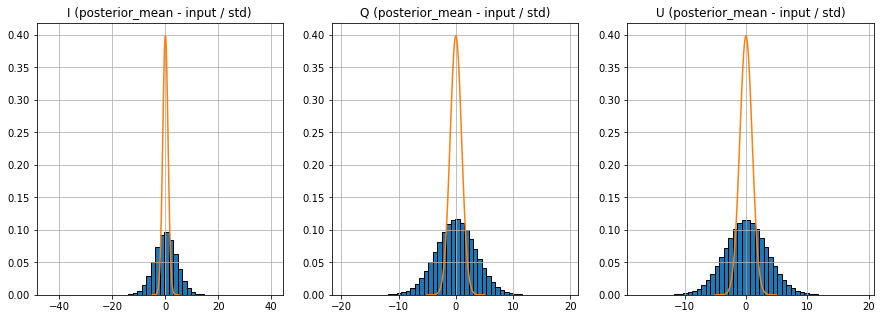

<Figure size 432x288 with 0 Axes>

In [84]:
plot_map_result(input_fm, fm_mean, fm_rms, 'fm')

# GAIN

In [76]:
start_pid = 2
end_pid = 10885

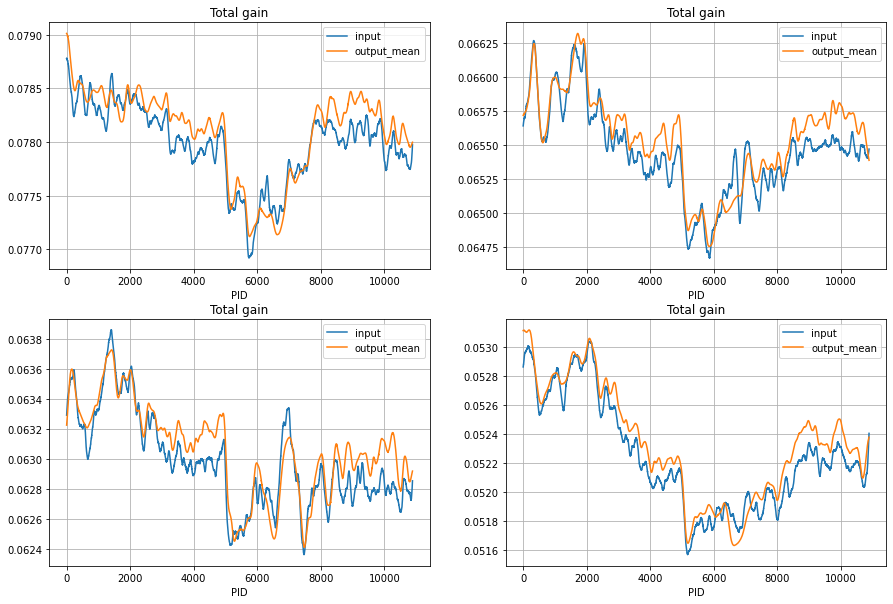

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].plot(input_gain[0][start_pid:end_pid], label='input')
ax[0][0].plot(gain_mean[0][start_pid:end_pid], label='output_mean')

ax[0][1].plot(input_gain[1][start_pid:end_pid], label='input')
ax[0][1].plot(gain_mean[1][start_pid:end_pid], label='output_mean')

ax[1][0].plot(input_gain[2][start_pid:end_pid], label='input')
ax[1][0].plot(gain_mean[2][start_pid:end_pid], label='output_mean')

ax[1][1].plot(input_gain[3][start_pid:end_pid], label='input')
ax[1][1].plot(gain_mean[3][start_pid:end_pid], label='output_mean')


for ax in ax.flat:
    ax.legend()
    ax.grid()
    ax.set_title('Total gain')
    ax.set_xlabel('PID')

plt.savefig('gain_mean.png',facecolor='w')

In [78]:
d = (gain_mean - input_gain) / gain_rms

/tmp/ipykernel_39643/2482569612.py:1: RuntimeWarning: divide by zero encountered in true_divide
  d = (gain_mean - input_gain) / gain_rms


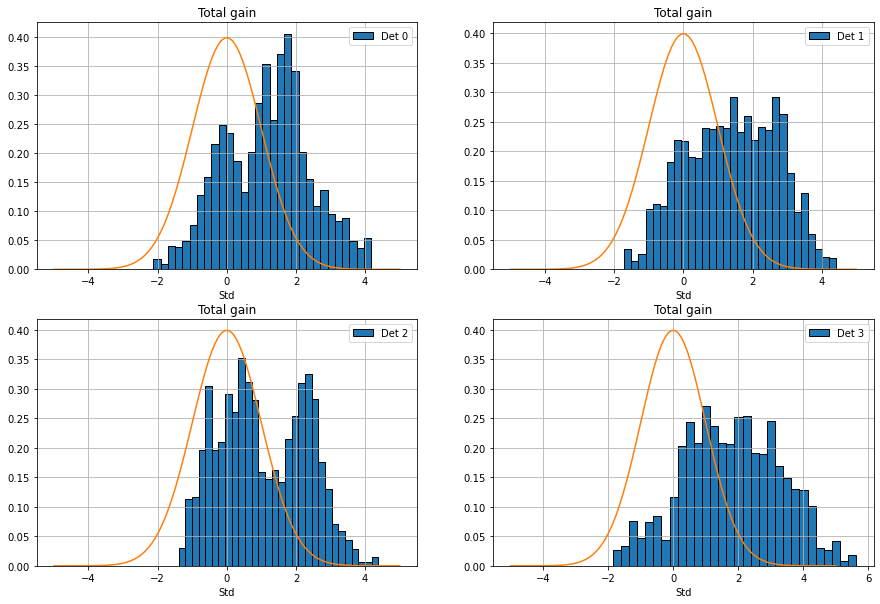

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0][0].hist(d[0][start_pid:end_pid], label='Det 0', density=True, bins= 30, ec='black')

ax[0][1].hist(d[1][start_pid:end_pid], label='Det 1', density=True, bins= 30, ec='black')

ax[1][0].hist(d[2][start_pid:end_pid], label='Det 2', density=True, bins= 30, ec='black')

ax[1][1].hist(d[3][start_pid:end_pid], label='Det 3', density=True, bins= 30, ec='black')

x = np.linspace(-5, 5, 100)
for ax in ax.flat:
    ax.plot(x, gaussian(x,0,1))
    ax.legend()
    ax.grid()
    ax.set_title('Total gain')
    ax.set_xlabel('Std')

plt.savefig('gain_hist.png',facecolor='w')